# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [2]:
import pickle

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import (RAggregate_profile, RAggregate,
    find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings, subset_data,
    find_te_het_partitions, find_feasible_sum_subsets
)
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

In [3]:
# import warnings
# warnings.filterwarnings("error")

## Helper functions

In [119]:
def format_data(df, outcome_col_id, chosen_covariates_idx):
    
    outcome_col = cols[outcome_col_id]
    df2 = df.copy()
    df2 = df2.dropna(subset=[outcome_col], axis=0)
    
    Z = df2.to_numpy()
    
    X = Z[:, chosen_covariates_idx]
    y = Z[:, outcome_col_id]
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y = y.reshape((-1, 1))

    return X, y


def read_pickle(results_dir, fname):

    outcome_fname = results_dir + fname + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)

    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    return R_set, R_profiles


def get_policy_means(M, R, X, y):
    
    num_profiles = 2**M
    profiles, profile_map = tva.enumerate_profiles(M)
    
    all_policies = tva.enumerate_policies(M, R)
    num_policies = len(all_policies)

    num_data = X.shape[0]

    # print(num_policies)
    
    policies_profiles = {}
    policies_profiles_masked = {}
    policies_ids_profiles = {}
    for k, profile in enumerate(profiles):
    
        policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
        unzipped_temp = list(zip(*policies_temp))
        policies_ids_k = list(unzipped_temp[0])
        policies_k = list(unzipped_temp[1])
        policies_profiles[k] = deepcopy(policies_k)
        policies_ids_profiles[k] = policies_ids_k
    
        profile_mask = list(map(bool, profile))
    
        # Mask the empty arms
        for idx, pol in enumerate(policies_k):
            policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
        policies_profiles_masked[k] = policies_k

    
    D = np.zeros(shape=y.shape, dtype=np.int64)
    profiles_in_data = []
    for i in range(num_data):
        policy_i = tuple([int(x) for x in X[i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        profiles_in_data.append(tva.policy_to_profile(policy_i))
        D[i, 0] = int(policy_idx[0])

    policy_means = loss.compute_policy_means(D, y, num_policies)
    
    policy_means_profiles = {}
    for k, profile in enumerate(profiles):
        D_k, y_k = subset_data(D, y, policies_ids_profiles[k])
    
        if D_k is None:
            policy_means_profiles[k] = None
        else:
            policy_means_k = policy_means[policies_ids_profiles[k], :]
            policy_means_profiles[k] = policy_means_k

    return (policy_means_profiles, policies_profiles_masked,
            policies_profiles, policy_means, policies_ids_profiles)


def find_gender_trt_con_pairs(policies, subset_indices, trt_idx, trt_label, con_label):
    trt_con_pairs = []
    found = []
    for i in range(len(subset_indices)):
        pol_i_idx = subset_indices[i]
        pol_i = policies[pol_i_idx]
        if pol_i_idx in found:
            continue
        found_match = False
        for j in range(i+1, len(subset_indices)):
            pol_j_idx = subset_indices[j]
            pol_j = policies[pol_j_idx]
            if pol_i[trt_idx] == pol_j[trt_idx]:
                continue
            if pol_i[:trt_idx] == pol_j[:trt_idx] and pol_i[(trt_idx+1):] == pol_j[(trt_idx+1):]:
                if pol_i[trt_idx] == con_label and pol_j[trt_idx] == trt_label:
                    found_match = True
                    trt_con_pairs.append([pol_i_idx, pol_j_idx])
                elif pol_i[trt_idx] == trt_label and pol_j[trt_idx] == con_label:
                    found_match = True
                    trt_con_pairs.append([pol_j_idx, pol_i_idx])
                if found_match:
                    found.append(pol_i_idx)
                    found.append(pol_j_idx)
                    break
    return trt_con_pairs


def get_counts(R_set, R_profiles,
               policies_profiles_masked,
               policies_profiles,
               policies_ids_profiles,
               policy_means,
               R_vals
            ):

    n_models = len(R_set)
    
    trt_idx = 0
    trt_label = 1
    con_label = 0
    gen_idx = 2
    mal_label = 1
    fem_label = 0

    if R_vals[0] == 3:
        trt_label += 1
        con_label += 1
    if R_vals[2] == 3:
        mal_label += 1
        fem_label += 1


    M = R_vals.shape[0]
    profiles, profile_map = tva.enumerate_profiles(M)
    all_policies = tva.enumerate_policies(M, R_vals)
    num_policies = len(all_policies)
    
    trt_indices = [idx for idx, p in enumerate(all_policies) if p[trt_idx] == trt_label]
    con_indices = [idx for idx, p in enumerate(all_policies) if p[trt_idx] == con_label]
    mal_indices = [idx for idx, p in enumerate(all_policies) if p[gen_idx] == mal_label]
    fem_indices = [idx for idx, p in enumerate(all_policies) if p[gen_idx] == fem_label]
        
    # Find treatment control pairs for each gender
    # The first element is control and the second element is treatment
    mal_trt_pairs = find_gender_trt_con_pairs(all_policies, mal_indices, trt_idx, trt_label, con_label)
    fem_trt_pairs = find_gender_trt_con_pairs(all_policies, fem_indices, trt_idx, trt_label, con_label)

    # The last four arms are the ones we care about
    active_arms = 4
    active_profiles, _ = tva.enumerate_profiles(active_arms)
    num_active_profiles = len(active_profiles)

    # Profiles with all the features (but not the treatment)
    profiles_x, _ = tva.enumerate_profiles(M-1)

    policies_to_active_profiles = {}
    active_profiles_policies_count = np.zeros(num_active_profiles)
    dosages = R_vals - 1
    fixed_poss = np.prod(dosages[:3])
    for i, active_prof in enumerate(active_profiles):
        prof_np = np.array(active_prof)
        dosages_prof_i = dosages[3:][prof_np > 0]
        num_policies_prof_i = fixed_poss * np.prod(dosages_prof_i)
        active_profiles_policies_count[i] = num_policies_prof_i
    
    active_profiles_policies_count_pooled = active_profiles_policies_count.copy()
    active_profiles_policies_count_gender = active_profiles_policies_count.copy()
    # print(R_vals)

    if R_vals[0] == 3 and R_vals[1] == 3 and R_vals[2] == 3:
        active_profiles_policies_count_pooled /= 2
        active_profiles_policies_count_gender /= 4
    
    elif R_vals[0] == 2 and R_vals[1] == 3 and R_vals[2] == 2:
        active_profiles_policies_count_pooled *= 2

    elif R_vals[0] == 3 and R_vals[1] == 3 and R_vals[2] == 2:
        active_profiles_policies_count_gender /= 2

    elif R_vals[0] == 2 and R_vals[1] == 2 and R_vals[2] == 2:
        active_profiles_policies_count_pooled[0] *= 4
        active_profiles_policies_count_pooled[1:] *= 4
        active_profiles_policies_count_gender[0] *= 2
        active_profiles_policies_count_gender[1:] *= 2
        
    elif R_vals[0] == 2 and R_vals[1] == 2 and R_vals[2] == 3:
        active_profiles_policies_count_pooled *= 2
        
    elif R_vals[0] == 3 and R_vals[1] == 2 and R_vals[2] == 2:
        active_profiles_policies_count_pooled *= 2
        
    elif R_vals[0] == 3 and R_vals[1] == 2 and R_vals[2] == 3:
        active_profiles_policies_count_gender /= 2
        
    elif R_vals[0] == 2 and R_vals[1] == 3 and R_vals[2] == 3:
        active_profiles_policies_count_gender /= 2

    for i, pol in enumerate(all_policies):
        last_four_arms = pol[3:]
        for j, prof in enumerate(active_profiles):
            if tva.policy_to_profile(last_four_arms) == prof:
                policies_to_active_profiles[i] = j

    total_ctr = n_models
    zero_eff_ctr = np.zeros(num_active_profiles)
    pos_eff_ctr = np.zeros(num_active_profiles)
    neg_eff_ctr = np.zeros(num_active_profiles)

    zero_eff_gender_ctr = np.zeros(num_active_profiles)
    pos_eff_gender_ctr = np.zeros(num_active_profiles)
    neg_eff_gender_ctr = np.zeros(num_active_profiles)


    hasse_edges = {}
    for k, profile in enumerate(profiles):
        policies_k = [x for x in all_policies if tva.policy_to_profile(x) == profile]
        hasse_edges[k] = extract_pools.lattice_edges(policies_k)

    for r, model_r in enumerate(R_set):
        pi_policies_profiles_r = {}

        for k, profile_idx in enumerate(model_r):

            trt_profile_k = tuple([1] + list(profiles_x[k]))
            trt_profile_k_idx = profile_map[trt_profile_k]
            trt_policies_k = policies_profiles_masked[trt_profile_k_idx]
            trt_policies_k_ids = policies_ids_profiles[trt_profile_k_idx]
            
            ctl_profile_k = tuple([0] + list(profiles_x[k]))
            ctl_profile_k_idx = profile_map[ctl_profile_k]
            ctl_policies_k = policies_profiles_masked[ctl_profile_k_idx]
            ctl_policies_k_ids = policies_ids_profiles[ctl_profile_k_idx]

            sigma_int_k = R_profiles[k][profile_idx][0]
            sigma_trt_k = R_profiles[k][profile_idx][2]
            sigma_ctl_k = R_profiles[k][profile_idx][3]

            # If both are None, then there is no data for either profile
            if sigma_trt_k is None and sigma_ctl_k is None:
                continue
                
            # If just one is None, then there is no data for that profile
            # So we cannot compute the TE
            if sigma_trt_k is None:
                ctl_pools_k_0, _ = extract_pools.extract_pools(ctl_policies_k, sigma_ctl_k, hasse_edges[ctl_profile_k_idx])
                ctl_pools_k = tva.profile_ids_to_univ_ids(ctl_pools_k_0, ctl_policies_k_ids)
                sigma_policies_k = {}
                for pi, pol_pi_list in ctl_pools_k.items():
                    for pol_pi_i in pol_pi_list:
                        sigma_policies_k[pol_pi_i] = pi

            elif sigma_ctl_k is None:
                trt_pools_k_0, _ = extract_pools.extract_pools(trt_policies_k, sigma_trt_k, hasse_edges[trt_profile_k_idx])
                trt_pools_k = tva.profile_ids_to_univ_ids(trt_pools_k_0, trt_policies_k_ids)
                sigma_policies_k = {}
                for pi, pol_pi_list in trt_pools_k.items():
                    for pol_pi_i in pol_pi_list:
                        sigma_policies_k[pol_pi_i] = pi
                        
            else:
                trt_pools_k_0, _ = extract_pools.extract_pools(trt_policies_k, sigma_trt_k, hasse_edges[trt_profile_k_idx])
                ctl_pools_k_0, _ = extract_pools.extract_pools(ctl_policies_k, sigma_ctl_k, hasse_edges[ctl_profile_k_idx])
                
                trt_pools_k = tva.profile_ids_to_univ_ids(trt_pools_k_0, trt_policies_k_ids)
                ctl_pools_k = tva.profile_ids_to_univ_ids(ctl_pools_k_0, ctl_policies_k_ids)
    
                sigma_pools_k, sigma_policies_k = extract_pools.get_trt_ctl_pooled_partition(
                            trt_pools_k, ctl_pools_k, sigma_int_k
                        )
            
            pi_policies_profiles_r[k] = sigma_policies_k
            
        # Aggregate pools
        pi_pools_r, pi_policies_r = extract_pools.__aggregate_pools__(pi_policies_profiles_r)
        mu_pools_r = loss.compute_pool_means(policy_means, pi_pools_r)
        
        policies_outcomes_est = np.zeros(shape=(num_policies,)) + np.inf
        
        for p, pool_id in pi_policies_r.items():
            policies_outcomes_est[p] = mu_pools_r[pool_id]

        mal_outcome_pairs = np.zeros(shape=(len(mal_trt_pairs), 2))
        fem_outcome_pairs = np.zeros(shape=(len(fem_trt_pairs), 2))
    
        for idx, pair in enumerate(mal_trt_pairs):
            con_pol_idx = pair[0]
            trt_pol_idx = pair[1]
            mal_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
            mal_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]
                    
        for idx, pair in enumerate(fem_trt_pairs):
            con_pol_idx = pair[0]
            trt_pol_idx = pair[1]
            fem_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
            fem_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]

        for i in range(len(mal_trt_pairs)):

            if all_policies[mal_trt_pairs[i][0]][3:] != all_policies[mal_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for male treatment-control pairs")
            if all_policies[fem_trt_pairs[i][0]][3:] != all_policies[fem_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for female treatment-control pairs")
            if all_policies[fem_trt_pairs[i][0]][3:] != all_policies[mal_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for male-female treatment-control pairs")
            
            y_mal_con = mal_outcome_pairs[i, 0]
            y_mal_trt = mal_outcome_pairs[i, 1]
            y_fem_con = fem_outcome_pairs[i, 0]
            y_fem_trt = fem_outcome_pairs[i, 1]

            if np.isinf(y_mal_con) and np.isinf(y_fem_con) and np.isinf(y_mal_trt) and np.isinf(y_fem_trt):
                continue

            # Find the profile
            mal_con_pol_idx = mal_trt_pairs[i][0]
            profile_i = policies_to_active_profiles[mal_con_pol_idx]

            # Compute effects and then count them
            if np.isinf(y_mal_con) or np.isinf(y_mal_trt):
                trt_eff_mal = 0
            else:
                trt_eff_mal = y_mal_trt - y_mal_con
            if np.isinf(y_fem_trt) or np.isinf(y_fem_con):
                trt_eff_fem = 0
            else:
                trt_eff_fem = y_fem_trt - y_fem_con
            gen_trt_eff = trt_eff_fem - trt_eff_mal

            # Treatment effects for male
            if trt_eff_mal > 0:
                pos_eff_ctr[profile_i] += 1
            elif trt_eff_mal < 0:
                neg_eff_ctr[profile_i] += 1
            elif trt_eff_mal == 0:
                zero_eff_ctr[profile_i] += 1
        
            # Treatment effects for female
            if trt_eff_fem > 0:
                pos_eff_ctr[profile_i] += 1
            elif trt_eff_fem < 0:
                neg_eff_ctr[profile_i] += 1
            elif trt_eff_fem == 0:
                zero_eff_ctr[profile_i] += 1

            # Treatment effects crossed with gender
            if gen_trt_eff > 0:
                pos_eff_gender_ctr[profile_i] += 1
            elif gen_trt_eff < 0:
                neg_eff_gender_ctr[profile_i] += 1
            elif gen_trt_eff == 0:
                zero_eff_gender_ctr[profile_i] += 1

        # break

    # print(active_profiles_policies_count)
    # print(active_profiles_policies_count_pooled)
    # print(active_profiles_policies_count_gender)
    
    # Normalize results
    # print("pooled", pos_eff_ctr + zero_eff_ctr + neg_eff_ctr)
    pos_eff_ctr /= active_profiles_policies_count_pooled
    zero_eff_ctr /= active_profiles_policies_count_pooled
    neg_eff_ctr /= active_profiles_policies_count_pooled
    print("pooled", pos_eff_ctr + zero_eff_ctr + neg_eff_ctr)

    # print("gender", pos_eff_gender_ctr + zero_eff_gender_ctr + neg_eff_gender_ctr)
    pos_eff_gender_ctr /= active_profiles_policies_count_gender
    zero_eff_gender_ctr /= active_profiles_policies_count_gender
    neg_eff_gender_ctr /= active_profiles_policies_count_gender
    print("gender", pos_eff_gender_ctr + zero_eff_gender_ctr + neg_eff_gender_ctr)

    results = {
        "0_pooled": zero_eff_ctr,
        "+_pooled": pos_eff_ctr,
        "-_pooled": neg_eff_ctr,
        "0_gender": zero_eff_gender_ctr,
        "+_gender": pos_eff_gender_ctr,
        "-_gender": neg_eff_gender_ctr,
        "n_models": total_ctr
    }

    return results

## Treatment effects

In [51]:
M = 7
R = np.array([3, 3, 3, 4, 4, 4, 4])

df = pd.read_csv("../Data/banerjee_miracle.csv")
# df["treatment"] = df["treatment"] + 1
# df["hh_edu"] = df["hh_edu"] + 1
# df["hh_gender"] = df["hh_gender"] + 1

cols = df.columns

results_dir = "../Results/microfinance/"

chosen_covariates_idx = [2, 3, 4, 6, 7, 9, 10]
chosen_covariates = [cols[x] for x in chosen_covariates_idx]
print(f"Covariates used are {chosen_covariates}")

outcome_names = ["Any Loan", "Informal Loan", "Female Biz", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Biz Assets"]

profile_labels_on = [
    "None",
    "Reg. Biz",
    "Reg. Debt",
    "Reg. Debt, Reg. Biz",
    "Biz",
    "Biz, Reg. Biz",
    "Biz, Reg. Debt",
    "Biz, Reg. Debt, Reg. Biz",
    "Chld",
    "Chld, Reg. Biz",
    "Chld, Reg. Debt",
    "Chld, Reg. Debt, Reg. Biz",
    "Chld, Biz",
    "Chld, Biz, Reg. Biz",
    "Chld, Biz, Reg. Debt",
    "Chld, Biz, Reg. Debt, Reg. Biz",
]

# profile_labels_on = [x[5:] for x in profile_labels_on]
profile_labels_on = [x.replace(",", " |") for x in profile_labels_on]

suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]

Covariates used are ['treatment', 'hh_edu', 'hh_gender', 'children', 'old_biz', 'area_debt_total_base', 'area_business_total_base']


In [120]:
all_results = {}
        

for outcome_col_id in range(14, 26):

    # if outcome_col_id != 24:
    #     continue

    outcome_col = cols[outcome_col_id]
    outcome_title = outcome_names[outcome_col_id-14]
    
    results_subdir = results_dir + outcome_col + "/"
    pkl_prefix = results_subdir + outcome_col
    
    num_active_arms = 4
    num_active_profiles = 2**num_active_arms
    
    zero_eff_ctr = np.zeros(num_active_profiles)
    neg_eff_ctr = np.zeros(num_active_profiles)
    pos_eff_ctr = np.zeros(num_active_profiles)
    zero_eff_gender_ctr = np.zeros(num_active_profiles)
    pos_eff_gender_ctr = np.zeros(num_active_profiles)
    neg_eff_gender_ctr = np.zeros(num_active_profiles)
    total_ctr = 0

    print(f"Outcome is {outcome_col}")

    for suffix in suffix_possibilities:

        # if suffix != "_trt_gen":
        #     continue

        this_df = df.copy()
        this_R = np.array([2, 2, 2, 4, 4, 4, 4])
        if "trt" not in suffix:
            this_df["treatment"] = this_df["treatment"] + 1
            this_R[0] += 1
        if "edu" not in suffix:
            this_df["hh_edu"] = this_df["hh_edu"] + 1
            this_R[1] += 1
        if "gen" not in suffix:
            this_df["hh_gender"] = this_df["hh_gender"] + 1
            this_R[2] += 1
        
        # R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_pruned")
        R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_te")

        if len(R_set) == 0:
            print(f"\tSuffix {suffix} has no models")
            continue
        print(f"\tWorking on suffix {suffix} - {len(R_set)} models")            
        
        X, y = format_data(this_df, outcome_col_id, chosen_covariates_idx)
        
        # num_data = X.shape[0]
        # print(f"There are {num_data} data points")
        
        pol_res = get_policy_means(M, this_R, X, y)
        policy_means_profiles = pol_res[0]
        policies_profiles_masked = pol_res[1]
        policies_profiles = pol_res[2]
        policies_means = pol_res[3]
        policies_ids_profiles = pol_res[4]
        
        ctr_res = get_counts(R_set, R_profiles,
                             policies_profiles_masked,
                             policies_profiles,
                             policies_ids_profiles,
                             policies_means,
                             this_R
                            )
        zero_eff_ctr_i = ctr_res["0_pooled"]
        pos_eff_ctr_i = ctr_res["+_pooled"]
        neg_eff_ctr_i = ctr_res["-_pooled"]
        zero_eff_gender_ctr_i = ctr_res["0_gender"]
        pos_eff_gender_ctr_i = ctr_res["+_gender"]
        neg_eff_gender_ctr_i = ctr_res["-_gender"]
        total_ctr_i = ctr_res["n_models"]

        zero_eff_ctr += zero_eff_ctr_i
        neg_eff_ctr += neg_eff_ctr_i
        pos_eff_ctr += pos_eff_ctr_i
        zero_eff_gender_ctr += zero_eff_gender_ctr_i
        neg_eff_gender_ctr += neg_eff_gender_ctr_i
        pos_eff_gender_ctr += pos_eff_gender_ctr_i
        total_ctr += total_ctr_i

    all_results[outcome_col] = {
        "0_pooled": zero_eff_ctr,
        "-_pooled": neg_eff_ctr,
        "+_pooled": pos_eff_ctr,
        "0_gender": zero_eff_gender_ctr,
        "-_gender": neg_eff_gender_ctr,
        "+_gender": pos_eff_gender_ctr,
        "n_models": total_ctr
    }

Outcome is anyloan_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Working on suffix _trt_gen - 655 models
pooled [655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655.
 655. 655.]
gender [655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655. 655.
 655. 655.]
	Suffix _trt has no models
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is informal_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
	Working on suffix _trt - 612 models
pooled [612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612.
 612. 612.]
gender [612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612. 612.
 612. 612.]
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is female_biz_pct_2
	Suffix  has no models
	Working on suffix _trt_edu_gen - 512 models
pooled [5

In [4]:
counter_fname = "../Results/microfinance/counter_results.pkl"

# with open(counter_fname, "wb") as f:
#     pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

with open(counter_fname, "rb") as f:
    all_results = pickle.load(f)

## Table for identifying patterns

In [28]:
pooled_counts = []
gender_counts = []

outcome_names = ["Any Loan", "Informal Loan", "Female Business Participation", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Business Assets"]

for col_name, counts in all_results.items():

    gender_matrix = np.concatenate((
        counts["+_gender"],
        counts["0_gender"],
        counts["-_gender"]),
        axis=0).reshape((3,-1))
    
    pooled_matrix = np.concatenate((
        counts["+_pooled"],
        counts["0_pooled"],
        counts["-_pooled"]),
        axis=0).reshape((3,-1))

    pooled_matrix = pooled_matrix / counts["n_models"]
    gender_matrix = gender_matrix / counts["n_models"]

    pooled_counts.append(pooled_matrix)
    gender_counts.append(gender_matrix)


profile_labels_on = [
    "None",
    "R. Bus",
    "R. Debt",
    "R. Debt, Reg. Bus",
    "Bus",
    "Bus, R. Bus",
    "Bus, R. Debt",
    "Bus, R. Debt, R. Bus",
    "Chld",
    "Chld, R. Bus",
    "Chld, R. Debt",
    "Chld, R. Debt, Reg. Bus",
    "Chld, Bus",
    "Chld, Bus, R. Bus",
    "Chld, Bus, R. Debt",
    "Chld, Bus, R. Debt, R. Bus",
]

In [48]:
pooled_counts[0].shape

(3, 16)

In [57]:
threshold = 0.8

pos_trt_matrix = []
neg_trt_matrix = []
any_trt_matrix = []
for idx, pooled_matrix in enumerate(pooled_counts):
    pos_idx = pooled_matrix[0, :] > threshold
    pos_trt_matrix.append(pos_idx)
    
    neg_idx = pooled_matrix[2, :] > threshold
    neg_trt_matrix.append(neg_idx)

    any_trt = pooled_matrix[1, :] + np.max(pooled_matrix[[0, 2], :], axis=0)
    any_idx = any_trt > threshold
    # print(pooled_matrix[[0, 2], :])
    # print(np.max(pooled_matrix[[0, 2], :], axis=0))
    # print("--")
    any_trt_matrix.append(any_idx)
    # break

pos_trt_matrix = np.array(pos_trt_matrix, dtype=np.int64).T
neg_trt_matrix = np.array(neg_trt_matrix, dtype=np.int64).T
any_trt_matrix = np.array(any_trt_matrix, dtype=np.int64).T

# print(pos_trt_matrix)

pos_trt_df = pd.DataFrame(pos_trt_matrix, columns=outcome_names)
pos_trt_df.index = profile_labels_on
pos_trt_df["sum"] = pos_trt_df.sum(axis=1)

neg_trt_df = pd.DataFrame(neg_trt_matrix, columns=outcome_names)
neg_trt_df.index = profile_labels_on
neg_trt_df["sum"] = neg_trt_df.sum(axis=1)

any_trt_df = pd.DataFrame(any_trt_matrix, columns=outcome_names)
any_trt_df.index = profile_labels_on
any_trt_df["loans"] = (any_trt_df["Informal Loan"] + any_trt_df["Any Loan"]) / 2
any_trt_df["hh_behavior"] = (any_trt_df["Durables"] + any_trt_df["Temptation"] + any_trt_df["Working Hours"]) / 3
any_trt_df["biz"] = (any_trt_df["Employees"] + any_trt_df["Profit"] + any_trt_df["Revenue"] + any_trt_df["Biz Assets"] + any_trt_df["Female Biz"]) / 5
any_trt_df["girls_school"] = any_trt_df["Girls in School"]
any_trt_df = any_trt_df.drop(outcome_names, axis=1)

any_trt_df

,loans,hh_behavior,biz,girls_school
None,1.0,0.666667,0.8,1
Reg. Biz,0.5,0.333333,0.4,1
Reg. Debt,0.5,0.333333,0.8,1
Reg. Debt | Reg. Biz,0.0,0.333333,0.4,0
Biz,1.0,0.666667,0.6,1
Biz | Reg. Biz,1.0,0.666667,1.0,1
Biz | Reg. Debt,0.5,0.666667,0.6,1
Biz | Reg. Debt | Reg. Biz,0.0,0.333333,0.4,1
Chld,1.0,1.000000,0.6,0
Chld | Reg. Biz,1.0,0.333333,0.4,0


In [38]:
neg_trt_df

,Any Loan,Informal Loan,Female Business Participation,Working Hours,Durables,Temptation,Expenditure,Profit,Revenue,Employees,Girls in School,Business Assets,sum
None,0,0,0,0,0,0,1,0,0,0,0,0,1
R. Bus,1,0,0,0,0,0,0,0,0,0,0,0,1
R. Debt,0,0,0,0,0,0,0,0,0,0,0,1,1
"R. Debt, Reg. Bus",1,0,0,0,0,0,0,0,0,0,0,1,2
Bus,0,0,0,0,0,0,0,0,0,0,0,0,0
"Bus, R. Bus",1,1,0,0,0,0,0,0,0,0,0,0,2
"Bus, R. Debt",0,0,0,0,0,0,0,0,0,0,0,0,0
"Bus, R. Debt, R. Bus",0,0,0,0,0,0,0,0,0,0,0,1,1
Chld,0,0,0,1,0,0,0,0,0,0,0,0,1
"Chld, R. Bus",1,1,0,0,0,0,0,0,0,0,0,0,2


### Single plots

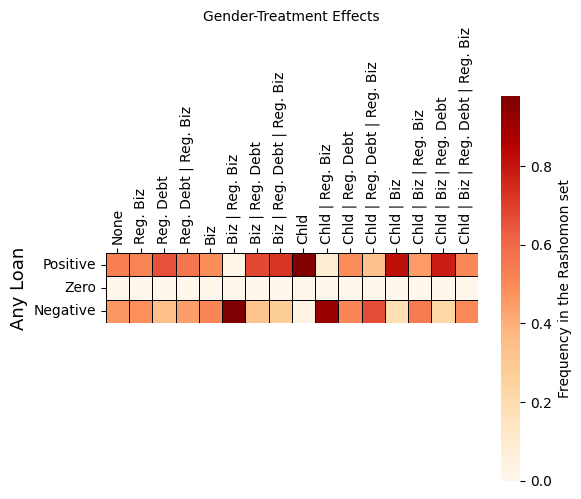

In [52]:
outcome_col_id = 14
outcome_col = cols[outcome_col_id]
outcome_title = outcome_names[outcome_col_id-14]

plot_gender_effects = True

if plot_gender_effects:
    plot_matrix = np.concatenate((
        all_results[outcome_col]["+_gender"],
        all_results[outcome_col]["0_gender"],
        all_results[outcome_col]["-_gender"]),
        axis=0).reshape((3,-1))
else:
    plot_matrix = np.concatenate((
        all_results[outcome_col]["+_pooled"],
        all_results[outcome_col]["0_pooled"],
        all_results[outcome_col]["-_pooled"]),
        axis=0).reshape((3,-1))

plot_matrix = plot_matrix / all_results[outcome_col]["n_models"]

fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(
    plot_matrix,
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    # annot=True,
    square=True,
    # vmin=0,
    # vmax=1,
    cbar_kws={
        "label": 'Frequency in the Rashomon set'
    }
)


# plt.title(outcome_title)
if plot_gender_effects:
    ax.set_xlabel("Gender-Treatment Effects")
else:
    ax.set_xlabel("Treatment Effects")
ax.set_ylabel(outcome_title, fontsize=13, rotation=90)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top") 

ax.set_yticks(np.arange(0, 3) + 0.5, ["Positive", "Zero", "Negative"], rotation=0)
ax.set_xticks(np.arange(0, len(profile_labels_on))+0.5, profile_labels_on, rotation=90)

fname = f"../Figures/microfinance/{outcome_col}.png"
if plot_gender_effects:
    fname = f"../Figures/microfinance/gender/{outcome_col}_gender.png"
    
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

### Subplots

In [125]:
pooled_counts = []
gender_counts = []

outcome_names = ["Any Loan", "Informal Loan", "Female Business Participation", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Business Assets"]

for col_name, counts in all_results.items():

    gender_matrix = np.concatenate((
        counts["+_gender"],
        counts["0_gender"],
        counts["-_gender"]),
        axis=0).reshape((3,-1))
    
    pooled_matrix = np.concatenate((
        counts["+_pooled"],
        counts["0_pooled"],
        counts["-_pooled"]),
        axis=0).reshape((3,-1))

    pooled_matrix = pooled_matrix / counts["n_models"]
    gender_matrix = gender_matrix / counts["n_models"]

    pooled_counts.append(pooled_matrix)
    gender_counts.append(gender_matrix)

profile_labels_on = [
    "None",
    "R. Bus",
    "R. Debt",
    "R. Debt, Reg. Bus",
    "Bus",
    "Bus, R. Bus",
    "Bus, R. Debt",
    "Bus, R. Debt, R. Bus",
    "Chld",
    "Chld, R. Bus",
    "Chld, R. Debt",
    "Chld, R. Debt, Reg. Bus",
    "Chld, Bus",
    "Chld, Bus, R. Bus",
    "Chld, Bus, R. Debt",
    "Chld, Bus, R. Debt, R. Bus",
]


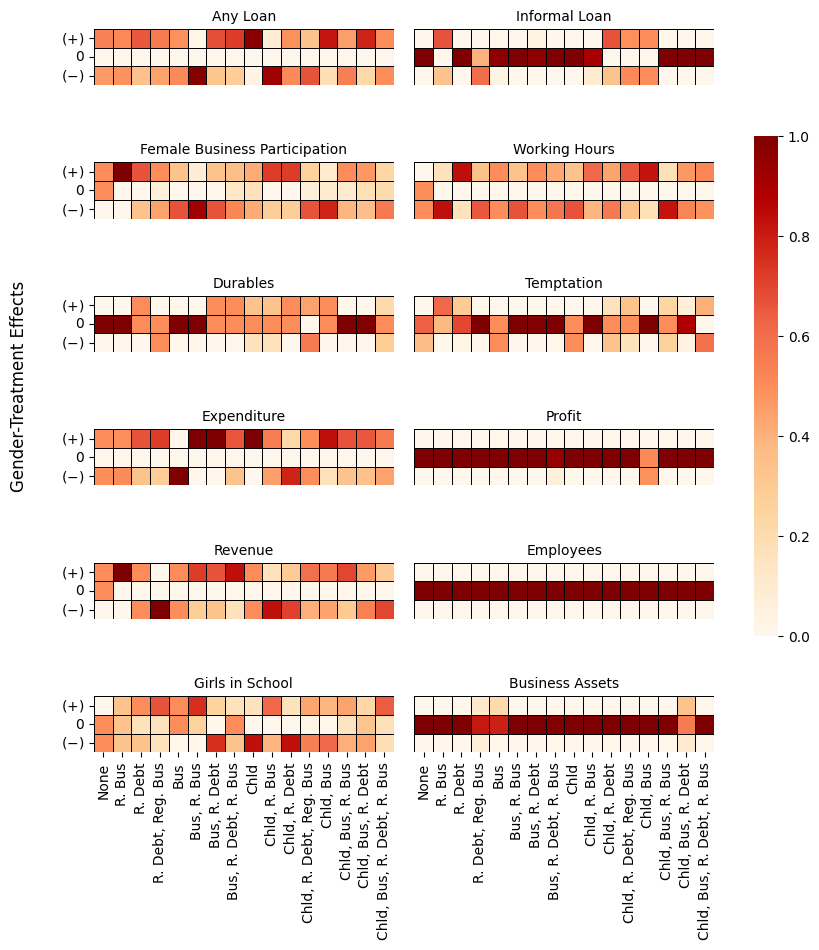

In [131]:
plot_gender_effects = True

fig = plt.figure(figsize=(8, 10)) #layout=None, facecolor='lightblue')
gs = fig.add_gridspec(nrows=6, ncols=4, #, left=0.05, right=0.75,
                      hspace=0.3, wspace=0.15)


cbar_ax = fig.add_axes([.95, .25, .03, .5])

for idx in range(12):
    i = idx // 2
    j = (idx % 2) * 2

    if plot_gender_effects:
        ax_ij = fig.add_subplot(gs[i, j:(j+2)])
        sns.heatmap(
            gender_counts[idx],
            cmap="OrRd",
            linewidths=0.5,
            linecolor="black",
            square=True,
            vmin=0,
            vmax=1,
            ax=ax_ij,
            cbar_ax=cbar_ax
        )
    else:
        ax_ij = fig.add_subplot(gs[i, j:(j+2)])
        sns.heatmap(
            pooled_counts[idx],
            cmap="OrRd",
            linewidths=0.5,
            linecolor="black",
            square=True,
            vmin=0,
            vmax=1,
            ax=ax_ij,
            cbar_ax=cbar_ax
        )
    ax_ij.set_title(outcome_names[idx], fontsize=10, rotation=0)
    ax_ij.set_yticks([])
    ax_ij.set_xticks([])
    if j == 0:
        ax_ij.set_yticks(np.arange(0, 3) + 0.5, [r"($+$)", "0", "($-$)"], rotation=0)
    if i == 5:
        ax_ij.set_xticks(np.arange(0, len(profile_labels_on))+0.5, profile_labels_on, rotation=90)


fname = "../Figures/microfinance/treatment_effects_mosaic.png"
fig.supylabel("Treatment Effects")
if plot_gender_effects:
    fname = "../Figures/microfinance/gender/treatment_effects_mosaic_gender.png"
    fig.supylabel("Gender-Treatment Effects")
    
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

# Error estimation plot
Useful for deciding an epsilon to prune at

Outcome is anyloan_amt_2
Total of 655 models
Best model loss 0.00340106834544921 and epsilon 0.00015628523250941462


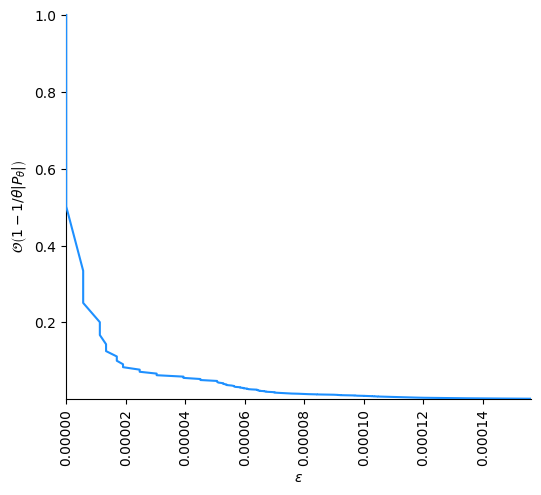

In [117]:
suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]
selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

for outcome_col_id in range(12, 23):

    if outcome_col_id != 14:
        continue

    outcome_col = cols[outcome_col_id]    
    results_subdir = results_dir + outcome_col + "/"
    pkl_prefix = results_subdir + outcome_col
    print(f"Outcome is {outcome_col}")

    # Read files
    # q0_all = []
    eps_all = []
    R_set_all = []
    R_profiles_all = []
    for suffix in selected_suffixes:
        outcome_fname = results_subdir + outcome_col + suffix + ".pkl"
        outcome_fname = results_subdir + outcome_col + suffix + "_te.pkl"
        
        with open(outcome_fname, "rb") as f:
            res_dict = pickle.load(f)
        
        # reg = res_dict["reg"]
        # q = res_dict["q"]
        # q0_all.append(res_dict["q0"])
        eps_all.append(res_dict["eps"])
        # H = res_dict["H"]
        R_set_all.append(res_dict["R_set"])
        R_profiles_all.append(res_dict["R_profiles"])

    
    model_losses = []
    suffix_loss_max = []
    for R_set, R_profiles in zip(R_set_all, R_profiles_all):
    # for R_item in R_list_all:
        this_max = -np.inf
        for r, model_r in enumerate(R_set):
            loss_r = 0
            for k, prof_k_id in enumerate(model_r):
                # loss_r += R_profiles[k].loss[prof_k_id]
                loss_r += R_profiles[k][prof_k_id][1]
            model_losses.append(loss_r)
            this_max = max(this_max, loss_r)
        suffix_loss_max.append(this_max)

    print(f"Total of {len(model_losses)} models")
    
    best_loss = np.min(model_losses)
    worst_loss = np.max(model_losses)
    eps = (worst_loss - best_loss) / best_loss
    
    print(f"Best model loss {best_loss} and epsilon {eps}")
    
    # print(f"Smallest model {np.min(model_sizes)}, largest model {np.max(model_sizes)}")
    
    sorted_losses = np.sort(model_losses)
    sorted_epsilon = sorted_losses / best_loss - 1
    
    num_models = np.arange(0, len(model_losses))+1
    model_errors = np.exp(-sorted_losses) * num_models

    #
    # Plot
    #
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.spines[['right', 'top']].set_visible(False)
    plt.xticks(rotation=90)

    errors_factor = 1 / model_errors
    
    ax.plot(sorted_epsilon, errors_factor,
            color="dodgerblue",
           zorder=3.1)
    
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(r"$\mathcal{O} \left( 1 - 1 / \theta |P_{\theta}| \right)$", rotation=90)

    
    # ax.set_yticks([1, 100, 200, 300, 400, 500])
    
    ax.set_xlim(0, np.max(sorted_epsilon))
    ax.set_ylim(np.min(errors_factor), np.max(errors_factor))
    
    # plt.savefig(f"../Figures/microfinance/est_error/{outcome_col}_est_error.png", dpi=300, bbox_inches="tight")
    plt.show()
    

# plt.show()

In [33]:
for outcome_col_id in range(14, 26):
    # print(cols[outcome_col_id])

    if outcome_col_id != 14:
        continue

    suffix = "_trt_gen"
    
    outcome_col = cols[outcome_col_id]
    outcome_fname = results_dir + outcome_col + "/" + outcome_col + suffix + ".pkl"
    # outcome_fname = results_dir + outcome_col + "/" + outcome_col + "_pruned.pkl"
    # print(outcome_fname)
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    # q0 = res_dict["q0"]
    eps = res_dict["eps"]
    # H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    # print(outcome_col_id, outcome_col, reg, q, eps, len(R_set))
    print(q, len(R_set))

    # break

0.0034016 655


In [350]:
R_set = find_feasible_combinations(R_profiles, 0.003105, np.inf, sorted=True)
print(len(R_set))

24


## Do the pruning to smaller epsilon

In [410]:
outcome_col_id = 22
outcome_col = cols[outcome_col_id]

results_subdir = results_dir + outcome_col + "/"
pkl_prefix = results_subdir + outcome_col

suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]


reg_all = []
q0_all = []
eps_all = []
R_set_all = []
R_profiles_all = []

selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

for suffix in selected_suffixes:
    outcome_fname = results_subdir + outcome_col + suffix + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg_all.append(res_dict["reg"])
    # q = res_dict["q"]
    q0_all.append(res_dict["q0"])
    eps_all.append(res_dict["eps"])
    # H = res_dict["H"]
    R_set_all.append(res_dict["R_set"])
    R_profiles_all.append(res_dict["R_profiles"])

    print(f"Suffix: {suffix}\t min q: {q0_all[-1]}\t max q: {res_dict['q']}\t num models: {len(res_dict['R_set'])}")


model_losses = []
for R_set, R_profiles in zip(R_set_all, R_profiles_all):
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        model_losses.append(loss_r)
print(f"Total models: {len(model_losses)}")


best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps_original = worst_loss / best_loss - 1

Suffix: 	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _trt_edu_gen	 min q: 0.1569678372103853	 max q: 0.15698	 num models: 8988
Suffix: _trt_edu	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _trt_gen	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _trt	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _edu_gen	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _edu	 min q: -inf	 max q: 0.15698	 num models: 0
Suffix: _gen	 min q: -inf	 max q: 0.15698	 num models: 0
Total models: 8988


In [413]:
desired_epsilon = 5e-5
loss_threshold = best_loss * (1 + desired_epsilon)

R_set_pruned = []
q_pruned = []
q0_pruned = []
model_losses_pruned = []
for idx, R_set in enumerate(R_set_all):
    R_set_pruned_i = []
    q_pruned_i = -np.inf
    q0_pruned_i = np.inf
    R_profiles = R_profiles_all[idx]
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        if loss_r <= loss_threshold:
            R_set_pruned_i.append(model_r)
            q_pruned_i = max(q_pruned_i, loss_r)
            q0_pruned_i = max(q0_pruned_i, loss_r)
            model_losses_pruned.append(loss_r)
    R_set_pruned.append(R_set_pruned_i)
    q_pruned.append(q_pruned_i)
    q0_pruned.append(q0_pruned_i)

eps_new = np.max(model_losses_pruned) / np.min(model_losses_pruned) - 1


print(f"Original size = {len(model_losses)}. After pruning = {len(model_losses_pruned)}")
print(f"Origial eps = {eps_original}. After pruning = {eps_new}")


# for idx, suffix in enumerate(selected_suffixes):
#     pruned_outcome_fname = results_subdir + outcome_col + suffix + "_pruned.pkl"

#     res_dict = {
#         "reg": reg_all[idx],
#         "q": q_pruned[idx],
#         "q0": q0_pruned[idx],
#         "eps": eps_new,
#         "H": np.inf,
#         "R_set": R_set_pruned[idx],
#         "R_profiles": R_profiles_all[idx]
#     }
    
#     with open(pruned_outcome_fname, "wb") as f:
#         pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

Original size = 8988. After pruning = 1252
Origial eps = 7.74777341334687e-05. After pruning = 4.998038787662473e-05
